状態ベクトルシミュレータで量子状態を調べる

In [27]:
# まずは全てインポート
import sys
sys.path.append(r'c:\Users\naoki\Jupyter_qiskit\kadai')

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
# qc_workbookはこのワークブック独自のモジュール（インポートエラーが出る場合はPYTHONPATHを設定するか、sys.pathをいじってください）
from qc_workbook.show_state import statevector_expr

print('notebook ready')

notebook ready


In [28]:
simulator = AerSimulator(method='statevector')
print(simulator.name)

aer_simulator_statevector


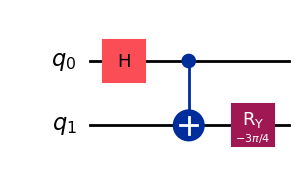

In [29]:
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)

circuit.draw('mpl')

In [30]:
def get_statevector_array(circuit):
    # 渡された回路のコピーを使う
    circuit = circuit.copy()
    # 量子回路の終状態の状態ベクトルを保存するインストラクション
    circuit.save_statevector()
    # 再び「おまじない」のtranspileをしてから、run()に渡す
    circuit = transpile(circuit, backend=simulator)
    job = simulator.run(circuit)
    result = job.result()
    qiskit_statevector = result.data()['statevector']

    # result.data()['statevector']は通常の配列オブジェクト（ndarray）ではなくqiskit独自のクラスのインスタンス
    # ただし np.asarray() で numpy の ndarray に変換可能
    return np.asarray(qiskit_statevector)

statevector = get_statevector_array(circuit)
print(type(statevector), statevector.dtype)
print(statevector)

<class 'numpy.ndarray'> complex128
[ 0.27059805+0.j  0.65328148+0.j -0.65328148+0.j  0.27059805+0.j]


In [31]:
expr = statevector_expr(statevector)

# Math()はLaTeXをタイプセットする関数
Math(expr)

<IPython.core.display.Math object>

問題1〜3は相対位相の導入や多重制御ゲートの利用例

問題１：量子ビット、相対位相付き

In [32]:
circuit = QuantumCircuit(1)
##################
### EDIT BELOW ###
##################
circuit.h(0)
circuit.p(np.pi / 2., 0)

##################
### EDIT ABOVE ###
##################

expr = statevector_expr(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))
Math(expr)

<IPython.core.display.Math object>

問題２：ベル状態、相対位相付き

In [33]:
circuit = QuantumCircuit(2)

##################
### EDIT BELOW ###
##################
circuit.h(0)
circuit.p(np.pi / 2., 0)
circuit.cx(0, 1)
##################
### EDIT ABOVE ###
##################

expr = statevector_expr(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))
Math(expr)

<IPython.core.display.Math object>

問題3: GHZ状態

In [34]:
circuit = QuantumCircuit(3)

##################
### EDIT BELOW ###
##################
circuit.h(0)
circuit.cx(0, 1)
circuit.mcx([0, 1], 2)
##################
### EDIT ABOVE ###
##################

expr = statevector_expr(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))
Math(expr)

<IPython.core.display.Math object>

問題4: Equal superposition 各量子ビットにHadamardを適用することで均等重ね合わせ状態を実現

In [35]:
num_qubits = 4

circuit = QuantumCircuit(num_qubits)

##################
### EDIT BELOW ###
##################
for i in range(4):
    circuit.h(i)
##################
### EDIT ABOVE ###
##################

sqrt_2_to_n = 2 ** (num_qubits // 2)
expr = statevector_expr(circuit, amp_norm=(1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n))
Math(expr)

<IPython.core.display.Math object>

問題5: 特定の基底の符号を反転させる制御の例

In [36]:
num_qubits = 4

circuit = QuantumCircuit(num_qubits)

##################
### EDIT BELOW ###
##################
for i in range(4):
    circuit.h(i)

circuit.x(1)
circuit.x(3)
circuit.mcp(np.pi, [0, 1, 2], 3)
circuit.x(1) # Xの逆操作はX
circuit.x(3)
##################
### EDIT ABOVE ###
##################

sqrt_2_to_n = 2 ** (num_qubits // 2)
expr = statevector_expr(circuit, amp_norm=(1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n))
Math(expr)

<IPython.core.display.Math object>

問題6: Equal superpositionに位相を付ける


In [37]:
num_qubits = 6

circuit = QuantumCircuit(num_qubits)

s = 2.5

##################
### EDIT BELOW ###
##################
for m in range(num_qubits):
    circuit.h(m)
    circuit.p(2. * np.pi * s / (2 ** (num_qubits - m)), m)
##################
### EDIT ABOVE ###
##################

sqrt_2_to_n = 2 ** (num_qubits // 2)
amp_norm = (1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n)
phase_norm = (2 * np.pi / (2 ** num_qubits), r'\frac{2 \pi i}{%d}' % (2 ** num_qubits))
expr = statevector_expr(circuit, amp_norm, phase_norm=phase_norm)
Math(expr)

<IPython.core.display.Math object>

測定結果にづいた分岐

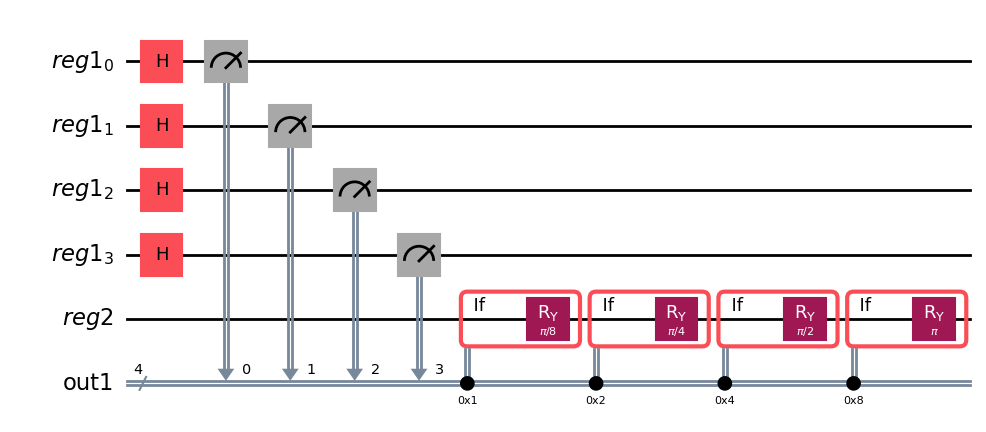

In [38]:
register1 = QuantumRegister(4, name='reg1')
register2 = QuantumRegister(1, name='reg2')
output1 = ClassicalRegister(4, name='out1') # 測定結果を保持する「古典レジスタ」オブジェクト

circuit = QuantumCircuit(register1, register2, output1)

# register1にequal superpositionを実現
circuit.h(register1)
# register1を測定し、結果をoutput1に書き込む
circuit.measure(register1, output1)

# output1の各位iの0/1に応じて、dtheta * 2^iだけRyをかけると、全体としてRy(2pi * j/16)が実現する
dtheta = 2. * np.pi / 16.

for idx in range(4):
    # circuit.***.c_if(classical_bit, 1) <- classical_bitが1のときに***ゲートをかける
    angle = dtheta * (2 ** idx)
    # Ryゲートを量子回路に追加
    #circuit.ry(angle, register2[0])
    # 古典レジスタの各ビットに基づいて条件付きでゲートを適用
    #circuit.append(circuit[0], [register2[0]]).c_if(output1, 1 << idx) # 1 << idxを条件として使う#改良点
    condition_value = 1 << idx  # 例：idx=2 → 0b0100 → 4

    # 新しい条件分岐構文を使う
    with circuit.if_test((output1, condition_value)):
        circuit.ry(angle, register2[0])
circuit.draw('mpl')

In [39]:
Math(statevector_expr(circuit, register_sizes=[4, 1]))

# cos(pi*0/16) = 1.000, sin(pi*0/16) = 0.000
# cos(pi*1/16) = 0.981, sin(pi*1/16) = 0.195
# cos(pi*2/16) = 0.924, sin(pi*2/16) = 0.383
# cos(pi*3/16) = 0.831, sin(pi*3/16) = 0.556
# cos(pi*4/16) = 0.707, sin(pi*4/16) = 0.707
# cos(pi*5/16) = 0.556, sin(pi*5/16) = 0.831
# cos(pi*6/16) = 0.383, sin(pi*6/16) = 0.924
# cos(pi*7/16) = 0.195, sin(pi*7/16) = 0.981
# cos(pi*8/16) = 0.000, sin(pi*8/16) = 1.000
# cos(pi*9/16) = -0.195, sin(pi*9/16) = 0.981
# cos(pi*10/16) = -0.383, sin(pi*10/16) = 0.924
# cos(pi*11/16) = -0.556, sin(pi*11/16) = 0.831
# cos(pi*12/16) = -0.707, sin(pi*12/16) = 0.707
# cos(pi*13/16) = -0.831, sin(pi*13/16) = 0.556
# cos(pi*14/16) = -0.924, sin(pi*14/16) = 0.383
# cos(pi*15/16) = -0.981, sin(pi*15/16) = 0.195

<IPython.core.display.Math object>

条件分岐としての制御ゲート

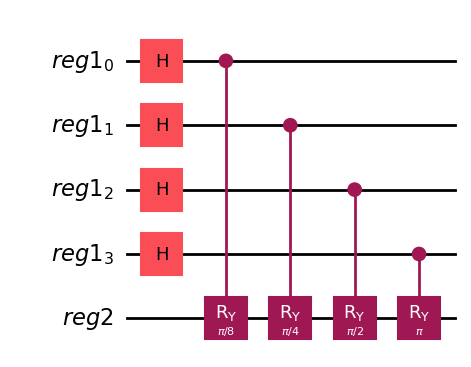

In [40]:
register1 = QuantumRegister(4, name='reg1')
register2 = QuantumRegister(1, name='reg2')

circuit = QuantumCircuit(register1, register2)

circuit.h(register1)

dtheta = 2. * np.pi / 16.

for idx in range(4):
    circuit.cry(dtheta * (2 ** idx), register1[idx], register2[0])

circuit.draw('mpl')

In [41]:
lines = statevector_expr(circuit, register_sizes=[4, 1], terms_per_row=6)
Math(r' \\ '.join(lines))

<IPython.core.display.Math object>

関数

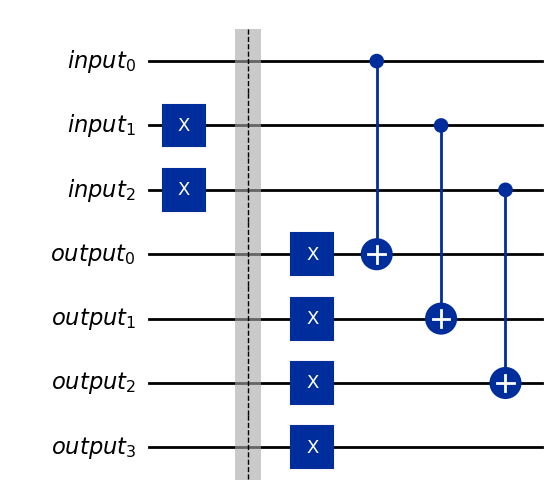

In [42]:
input_register = QuantumRegister(3, name='input')
output_register = QuantumRegister(4, name='output')

circuit = QuantumCircuit(input_register, output_register)

# input_registerに適当な値（6）を入力
circuit.x(input_register[1])
circuit.x(input_register[2])

circuit.barrier()

# ここからが引き算をするU_f
# まずoutput_registerの全てのビットを立てる
circuit.x(output_register)
for idx in range(3):
    # その上で、CNOTを使ってinput_registerでビットが1である時にoutput_registerの対応するビットが0にする
    circuit.cx(input_register[idx], output_register[idx])

circuit.draw('mpl')

In [43]:
Math(statevector_expr(circuit, register_sizes=[3, 4]))

<IPython.core.display.Math object>

SWAPテスト

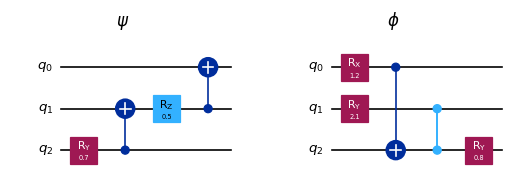

In [44]:
data_width = 3

fig, axs = plt.subplots(1, 2)

# 適当な状態|ψ>を作る回路
psi_circuit = QuantumCircuit(data_width, name='|ψ>')
psi_circuit.ry(0.7, 2)
psi_circuit.cx(2, 1)
psi_circuit.rz(0.5, 1)
psi_circuit.cx(1, 0)
psi_circuit.draw('mpl', ax=axs[0])
axs[0].set_title(r'$\psi$')

# 適当な状態|φ>を作る回路
phi_circuit = QuantumCircuit(data_width, name='|φ>')
phi_circuit.rx(1.2, 0)
phi_circuit.ry(2.1, 1)
phi_circuit.cx(0, 2)
phi_circuit.cz(1, 2)
phi_circuit.ry(0.8, 2)
phi_circuit.draw('mpl', ax=axs[1])
axs[1].set_title(r'$\phi$')

# パーツが全て揃ったので、内積を計算する回路を作る
reg_data1 = QuantumRegister(data_width, name='data1')
reg_data2 = QuantumRegister(data_width, name='data2')
reg_test = QuantumRegister(1, name='test')
out = ClassicalRegister(1, name='out')

circuit = QuantumCircuit(reg_data1, reg_data2, reg_test, out, name='SWAP_test')
# 状態|ψ>と|φ>をデータレジスタに実現
# 他の回路や別に定義したゲートを回路オブジェクトに組み込むときはappend()メソッドを使う
# qargsでもとの回路の量子ビットを組み込み先のどの量子ビットに対応させるかを指定する
circuit.append(psi_circuit, qargs=reg_data1)
circuit.append(phi_circuit, qargs=reg_data2)

# 回路図が見やすくなるようにバリアを入れる（計算上は何もしない操作）
circuit.barrier()

# ここからがSWAPテスト
circuit.h(reg_test)

for idx in range(data_width):
    circuit.cswap(reg_test[0], reg_data1[idx], reg_data2[idx])

circuit.h(reg_test)

circuit.measure(reg_test, out)

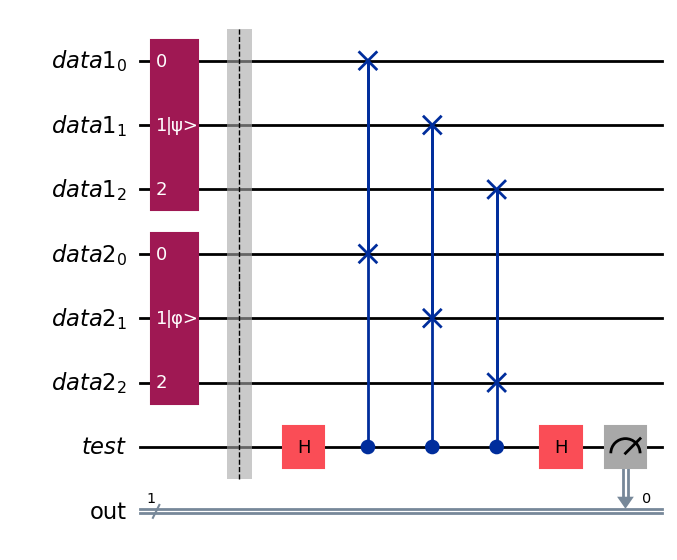

In [45]:
circuit.draw('mpl')

In [46]:
Math(statevector_expr(psi_circuit, state_label=r'\psi'))

<IPython.core.display.Math object>

In [47]:
Math(statevector_expr(phi_circuit, state_label=r'\phi'))

<IPython.core.display.Math object>

In [48]:
sv_psi = get_statevector_array(psi_circuit)
sv_phi = get_statevector_array(phi_circuit)
print(np.square(np.abs(np.sum(sv_psi.conjugate() * sv_phi))))

0.20287760299395322


In [49]:
simulator = AerSimulator()
sampler = Sampler()
shots = 1000000

circuit = transpile(circuit, backend=simulator)
job_result = sampler.run([circuit], shots=shots).result()
counts = job_result[0].data.out.get_counts()

print((counts['0'] - counts['1']) / shots)

0.202448


逆回路の利用

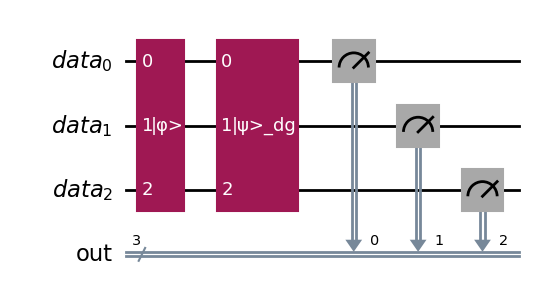

In [50]:
reg_data = QuantumRegister(data_width, name='data')
out = ClassicalRegister(data_width, name='out')

circuit = QuantumCircuit(reg_data, out)

circuit.append(phi_circuit, qargs=reg_data)
# psi_circuit.inverse() -> psi_circuitの逆回路
circuit.append(psi_circuit.inverse(), qargs=reg_data)

# 量子ビット[0, 1, 2, ...]を測定し、結果を古典ビット[0, 1, 2, ...]に書き出す
circuit.measure(range(data_width), range(data_width))

circuit.draw('mpl')

In [51]:
shots = 1000000

circuit = transpile(circuit, backend=simulator)
job_result = sampler.run([circuit], shots=shots).result()
counts = job_result[0].data.out.get_counts()

print(counts['000'] / shots)

0.203085


複製不可能定理とテレポーテーション

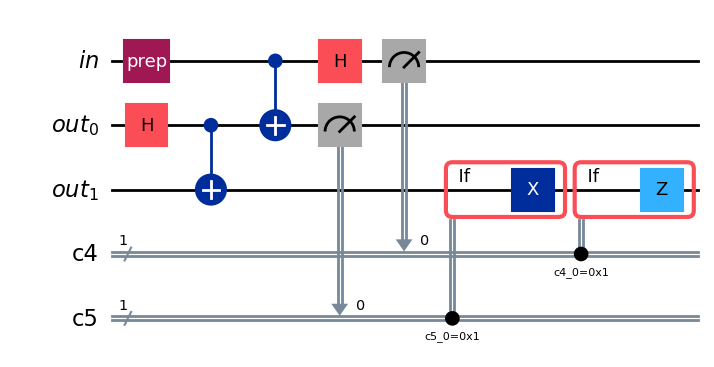

In [55]:
# まずは入力ビットを適当な状態にする回路を作る
# circuit.u (U3 gate)は3パラメータで一つの量子ビットを完全にコントロールするゲート
prep_circuit = QuantumCircuit(1, name='prep')
prep_circuit.u(0.7, 1.8, 2.1, 0)

reg_in = QuantumRegister(1, name='in')
reg_out = QuantumRegister(2, name='out')
res_in = ClassicalRegister(1)
res_ent = ClassicalRegister(1)

circuit = QuantumCircuit(reg_in, reg_out, res_in, res_ent)

# まずreg_inをprep_circuitの状態にする
circuit.append(prep_circuit, qargs=reg_in)

# reg_outはベル状態に用意する
circuit.h(reg_out[0])
circuit.cx(reg_out[0], reg_out[1])

# reg_inとreg_outの第一ビットをエンタングルさせる
circuit.cx(reg_in[0], reg_out[0])

# reg_inにアダマールゲートをかけ、測定する
circuit.h(reg_in[0])
circuit.measure(reg_in[0], res_in[0])

# reg_outのエンタングルしたビットも測定する
circuit.measure(reg_out[0], res_ent[0])

# reg_out[1]にreg_in, reg_entの測定結果に応じたゲートをかける
#circuit.x(reg_out[1]).c_if(res_ent[0], 1)
#circuit.z(reg_out[1]).c_if(res_in[0], 1)
# 条件付き補正ゲート（新しい構文）
with circuit.if_test((res_ent[0], 1)):
    circuit.x(reg_out[1])
with circuit.if_test((res_in[0], 1)):
    circuit.z(reg_out[1])

circuit.draw('mpl')

In [53]:
Math(statevector_expr(prep_circuit, state_label=r'\text{in}'))

<IPython.core.display.Math object>

In [54]:
Math(statevector_expr(circuit, register_sizes=(1, 1, 1)))

<IPython.core.display.Math object>